# Predict `Subject Age`

In [1]:
%matplotlib inline

In [5]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import time
from pathlib import Path

In [6]:
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [9,6]

In [7]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2021-09-06 00:55:37.020660: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-06 00:55:37.021725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-06 00:55:37.150643: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-06 00:55:37.150691: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-149): /proc/driver/nvidia/version does not exist


IndexError: list index out of range

In [8]:
phenotype = 'Subject Age'

In [9]:
#load data
aging_dir = Path('/home/ubuntu/a/aging/aging')

with open(aging_dir/'aging-cytof-data.obj', 'rb') as f:
    allData = pickle.load(f)
samples = allData["samples"]
cyto_data = allData['expr_list']
# Truncate cytodata
cyto_data = cyto_data[ :, :int(5e3)]
markers = allData["marker_names"]

print(f'Dimensions of cyto_data: {cyto_data.shape}')
print(f'Dimensions of samples: {samples.shape}')
print(f'Names of the makers: {markers.values}')

Dimensions of cyto_data: (260, 5000, 27, 1)
Dimensions of samples: (260, 85)
Names of the makers: ['CELL_LENGTH' 'DEAD' 'CD19' 'CD4' 'CD8' 'IGD' 'CD85J' 'CD16' 'CD3' 'CD38'
 'CD27' 'CD14' 'CD94' 'CCR7' 'CD45RA' 'CD20' 'CD127' 'CD33' 'CD28' 'CD24'
 'CD161' 'TCRGD' 'CD56' 'HLADR' 'CD25' 'DNA1' 'DNA2']


count    260.000000
mean      68.303846
std       15.169696
min       41.000000
25%       55.000000
50%       69.000000
75%       82.000000
max       90.000000
Name: Subject Age, dtype: float64


<AxesSubplot:ylabel='Frequency'>

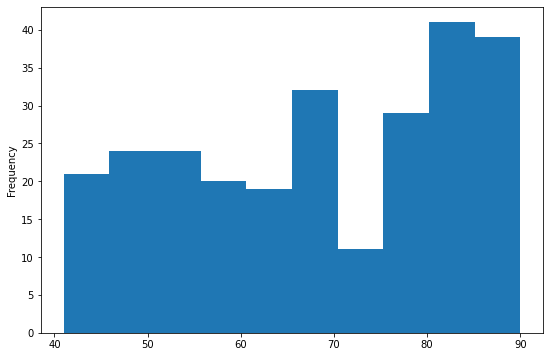

In [10]:
print(samples[phenotype].describe())
samples[phenotype].plot.hist()

In [11]:
##### Step 3: split train, validation and test######
x = []
y = []
for i, row in samples.iterrows():
    x.append(cyto_data[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

In [12]:
model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(3, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(6, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(3, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
])
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5000, 1, 3)        84        
_________________________________________________________________
batch_normalization (BatchNo (None, 5000, 1, 3)        12        
_________________________________________________________________
activation (Activation)      (None, 5000, 1, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5000, 1, 6)        24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 5000, 1, 6)        24        
_________________________________________________________________
activation_1 (Activation)    (None, 5000, 1, 6)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 6)           0

2021-09-06 00:56:02.568587: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-06 00:56:02.568863: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [13]:
%%time
model_store = Path(f'Result/saved_weights_{phenotype}.hdf5')

# save the best performing model
checkpointer = ModelCheckpoint(filepath=model_store, 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=200, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

2021-09-06 00:56:05.603794: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 105300000 exceeds 10% of free system memory.
2021-09-06 00:56:05.853404: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-06 00:56:05.885915: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2999995000 Hz


Epoch 1/200


2021-09-06 00:56:06.512102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32400000 exceeds 10% of free system memory.
2021-09-06 00:56:06.512106: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32400000 exceeds 10% of free system memory.
2021-09-06 00:56:06.512102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32400000 exceeds 10% of free system memory.
2021-09-06 00:56:06.534122: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 32400000 exceeds 10% of free system memory.


4/4 [==============================] - 1s 212ms/step - loss: 0.3873 - mean_absolute_error: 0.3873 - val_loss: 0.5998 - val_mean_absolute_error: 0.5998
Epoch 2/200
4/4 [==============================] - 1s 131ms/step - loss: 0.3930 - mean_absolute_error: 0.3930 - val_loss: 0.5941 - val_mean_absolute_error: 0.5941
Epoch 3/200
4/4 [==============================] - 1s 130ms/step - loss: 0.3607 - mean_absolute_error: 0.3607 - val_loss: 0.5876 - val_mean_absolute_error: 0.5876
Epoch 4/200
4/4 [==============================] - 1s 130ms/step - loss: 0.3466 - mean_absolute_error: 0.3466 - val_loss: 0.5809 - val_mean_absolute_error: 0.5809
Epoch 5/200
4/4 [==============================] - 1s 127ms/step - loss: 0.3354 - mean_absolute_error: 0.3354 - val_loss: 0.5740 - val_mean_absolute_error: 0.5740
Epoch 6/200
4/4 [==============================] - 1s 138ms/step - loss: 0.3275 - mean_absolute_error: 0.3275 - val_loss: 0.5670 - val_mean_absolute_error: 0.5670
Epoch 7/200
4/4 [=================

In [14]:
rt

107.06184983253479

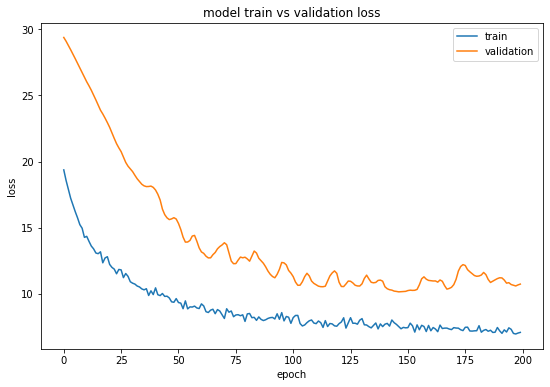

In [15]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
#### Step 7: test the final model #####
final_model = load_model(model_store)
x_test = x_valid
y_test = y_valid
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])

In [17]:
errors = age_range * (pd.Series(y_test)-pd.Series(y_scores))
errors.describe()

count    65.000000
mean     -0.949201
std      12.317975
min     -31.485485
25%      -8.376865
50%      -1.617268
75%       6.876638
max      29.140199
dtype: float64

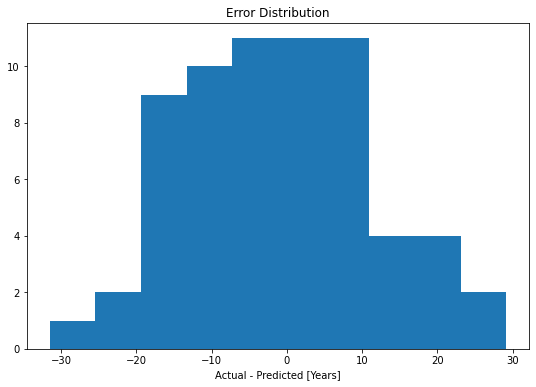

In [18]:
plt.hist(errors)
plt.title('Error Distribution')
plt.xlabel('Actual - Predicted [Years]')
plt.show()

[ 0.402583   43.17279581]


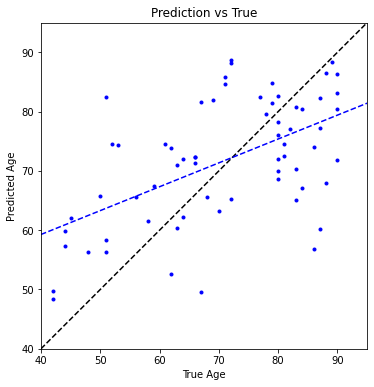

In [19]:
age_true = y_test*age_range + age_min
age_pred = y_scores*age_range + age_min
plt.plot(age_true, age_pred,'b.')
plt.axis('square')
plt.xlim((40,95))
plt.ylim((40,95))
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Prediction vs True')
plt.plot([40,95],[40,95],'--k')
coef = np.polyfit(age_true, age_pred, 1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([40,95], poly1d_fn([40,95]), '--b')
plt.show()